<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/denso05_Rayleigh_correlated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
np.random.seed(4) # 乱数のseedは固定

import scipy as sp
from scipy.linalg import circulant
from scipy.special import jv

import matplotlib.pyplot as plt
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.size"] = 12

#import IPython.display
#from tqdm import tqdm # Progress bar

In [2]:
fd = 200 # ドップラー周波数
fs = 20000 # サンプル周波数
Ts = 1/fs # サンプル時間
N = 2**13 # 出力サンプル数 2^22 くらいにするとacfが一致するのはRで作ったときに知っているのだが，このプログラムは止まってしまう

In [3]:
np.arange(N)

# 各インデックスの時刻
t_ax = np.arange(N)*Ts

# 各インデックスの周波数 # DFTを前提としていることに注意
f_idx = np.concatenate([ np.arange(int(N/2)), np.arange(-int(N/2),0,1) ])
f_ax = f_idx * (fs/N)

$ \sqrt{\hat{\rho}} $

In [4]:
rho_hat = (np.abs(f_ax) <= fd) * np.sqrt( 1/ ( np.pi*fd*( 1-(f_ax*(abs(f_ax)<=fd)/fd)**2 ) ) )
rho_hat_sq = (np.abs(f_ax) <= fd) * np.sqrt( 1/ ( np.pi*fd*np.sqrt( 1-(f_ax*(abs(f_ax)<=fd)/fd)**2 ) ) )

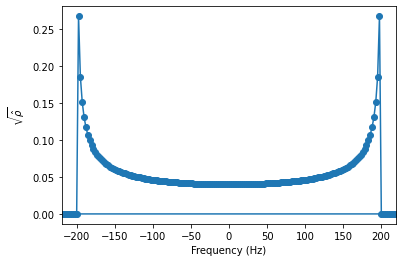

In [5]:
#plt.xlim(-int(N/2**6), int(N/2**6))
plt.xlim(-fd-20,fd+20)
plt.xlabel(r"Frequency (Hz)")
plt.ylabel(r"$\sqrt{\hat{\rho}}$")
#plt.plot(f_idx, rho_hat)
plt.plot(f_ax, rho_hat, "o-")

In [6]:
h_hat = rho_hat_sq * (np.random.normal(loc=0.0, scale=np.sqrt(1/2), size=N)+1j*np.random.normal(loc=0.0, scale=np.sqrt(1/2), size=N))
# rho_hat_sqが0のところを乱数生成するのは，無駄ではある

In [7]:
h = np.fft.ifft(h_hat)

絶対値はちゃんと計算していない．（手抜きだが）電力利得の期待値が1になるように正規化．短い区間に過ぎないのはイマイチ

In [8]:
h = h / np.sqrt(np.average(abs(h)**2))
r = abs(h)
g = r**2

In [9]:
# IQ平面を書くときの幅の設定
W = np.ceil(np.max(np.concatenate([np.abs(np.real(h)), np.abs(np.imag(h))])))

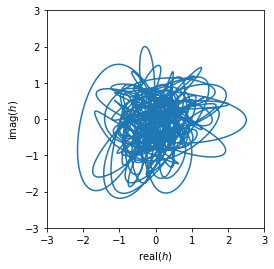

In [10]:
plt.axes().set_aspect('equal')
plt.xlim(-W,W)
plt.ylim(-W,W)
plt.xlabel(r"$\mathrm{real}(h)$")
plt.ylabel(r"$\mathrm{imag}(h)$")
plt.plot(np.real(h), np.imag(h))
plt.savefig("denso05_H_correlated.pdf", transparent=True, bbox_inches='tight')

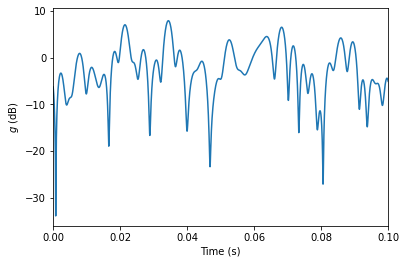

In [11]:
plt.xlabel("Time (s)")
plt.ylabel("$g$ (dB)")
plt.xlim(0,0.1)
plt.plot(t_ax, 10*np.log10(g))
plt.savefig("denso05_G_correlated.pdf", transparent=True, bbox_inches='tight')

In [12]:
# N = 2^14とかになるとクラッシュする
# 正規化していない
h_acf = circulant(np.conjugate(h)).T @ h

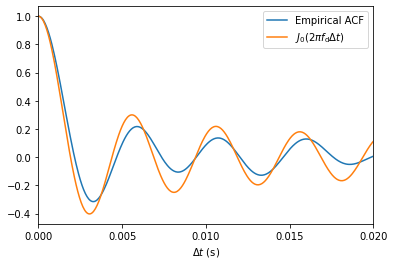

In [13]:
# real partだけ取っていることの妥当性を検証していない
ttics = np.arange(0, 0.025, 0.005)
plt.xticks(ttics)
plt.xlim(0,0.02)
plt.xlabel(r"$\Delta t$ (s)")
plt.plot(t_ax, np.real( h_acf ) / np.real( h_acf[0]) , label=r"Empirical ACF")
plt.plot(t_ax, jv(0, 2*np.pi*fd*t_ax), label=r"$J_0(2\pi f_\mathrm{d} \Delta t)$")
plt.legend()
plt.savefig("denso05_H_correlated_acf.pdf", transparent=True, bbox_inches='tight')

## 以下はテスト

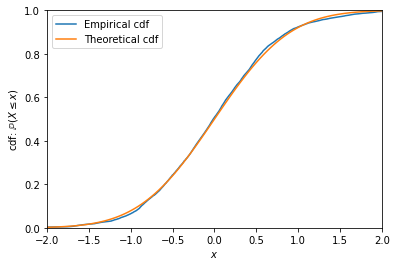

In [14]:
plt.xlabel(r"$x$")
plt.ylabel(r"cdf: $\mathbb{P}(X \leq x)$")
plt.xlim(-2,2)
plt.ylim(0,1)
plt.plot(np.sort(np.real(h)), np.arange(N)/N, label="Empirical cdf")
xs = np.linspace(-2, 2, num=100)
x_cdf = (1+sp.special.erf(xs))/2
# x_cdf = stats.norm.cdf(x=xs, loc=0, scale=np.sqrt(1/2)) # これでもよい
plt.plot(xs, x_cdf, label="Theoretical cdf")
plt.legend()

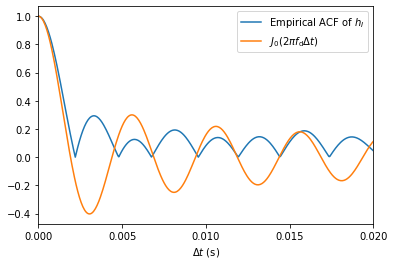

In [15]:
hI = np.real(h)
hI_acf = circulant(np.conjugate(hI)).T @ hI
plt.xticks(ttics)
plt.xlim(0,0.02)
plt.xlabel(r"$\Delta t$ (s)")
#plt.ylabel(r"Real part of autocorrelation")
plt.plot(t_ax, np.abs( hI_acf ) / np.real( hI_acf[0]) , label=r"Empirical ACF of $h_I$")
#plt.plot(t_ax, np.imag( h_acf ) / np.real( h_acf[0]) )
plt.plot(t_ax, jv(0, 2*np.pi*fd*t_ax), label=r"$J_0(2\pi f_\mathrm{d} \Delta t)$")
plt.legend()